In [97]:
# importing necessary libraries
import glob
import numpy as np
import re
import requests
import pandas as pd
from pyvi.ViTokenizer import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
# read all file csv in raw folder
path = r'raw'
all_files = glob.glob(path + "/*.csv")
history = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [3]:
history.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             650 non-null    object 
 1   desc_video      630 non-null    object 
 2   like_count      650 non-null    object 
 3   comment_count   650 non-null    object 
 4   like            650 non-null    int64  
 5   time_container  650 non-null    object 
 6   timestamp       650 non-null    float64
 7   user            650 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 40.8+ KB


In [4]:
history.replace(np.nan, '', inplace=True)
history['desc_video'] = history['desc_video'].astype(str)


In [5]:
# split attributes about video base on url
for i in range(len(history)):
    text = history.loc[i, 'url'].split('/')[-1]
    info_video = re.findall(r'\d+', text)
    history.loc[i, 'id'] = info_video[0]  # id video
    history.loc[i, 'from_webapp'] = info_video[1]  # from_webapp
    history.loc[i, 'web_id'] = info_video[2]  # from_webapp

history.drop_duplicates(subset='id', inplace=True)
history.reset_index(inplace=True, drop=True)


## Preprocess sentences


In [6]:
def download_stopwords():
    """
    Get stopwords from GitHub
    """
    stopwords_url = 'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt'
    response = requests.get(stopwords_url)
    stopwords = response.text.split('\n')
    stopwords = set(stopwords)
    return stopwords


stopwords = download_stopwords()


In [7]:
def filter_stop_words(sentences, stop_words):
    new_sent = [word for word in sentences.split() if word not in stop_words]
    sentences = ' '.join(new_sent)
    return sentences


def de_emojify(text):
    regrex_pattern = re.compile(pattern="["
                                        u"\U0001F600-\U0001F64F"  # emoticons
                                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                        "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', text)


def preprocess(text, tokenized=True, lowercased=True):
    text = text.lower() if lowercased else text
    text = de_emojify(text)
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = re.sub(r'[^\w]', ' ', text)
    text = filter_stop_words(text, stopwords)
    return text


def pre_process_features(sentences, tokenized=True, lowercased=True):
    sentences = [preprocess(str(p), tokenized=tokenized,
                            lowercased=lowercased) for p in list(sentences)]
    for idx, ele in enumerate(sentences):
        if not ele:
            np.delete(sentences, idx)
    return sentences


# Preprocess description
history['desc_cleaned'] = pre_process_features(history['desc_video'])


In [9]:
from sklearn.model_selection import train_test_split
# train test split
train, test = train_test_split(
    history, train_size=0.1, shuffle=False)
# get indices of video which user liked
indices_liked_train = np.where(train['like'] == 1)[0]
indices_liked_test = np.where(test['like'] == 1)[0]


In [55]:
liked_videos = history.loc[history['like'] == 1, 'id'].values


## Evaluate recommender system


In [67]:
def precision(actual, predicted, k):
    act_set = list(actual)
    pred_set = list(predicted[:k]) if k < len(act_set) else list(predicted)
    right_pred = [act_set[i] == pred_set[i] for i in range(k)]
    result = sum(right_pred) / float(k)
    return result


def recall(actual, predicted, k):
    act_set = list(actual)
    pred_set = list(predicted[:k]) if k < len(act_set) else list(predicted)
    right_pred = [act_set[i] == pred_set[i] for i in range(k)]
    result = sum(right_pred) / float(len(act_set))
    return result


# TF-IDF


In [10]:
# Term Frequency-Inverse Document frequency
tfidf = TfidfVectorizer()
descr_train = tfidf.fit_transform(train['desc_cleaned'])
avg_descr_liked = np.mean(descr_train[indices_liked_train], axis=0)


In [11]:
descr_test = tfidf.transform(test['desc_cleaned'])


In [12]:
# measure the similarity between 2 description vector base on Cosine_Similarity
sim_matrix_test = linear_kernel(avg_descr_liked, descr_test)


In [13]:
def recommend_video_based_on_desc(dataset, similarity_score, num_video=-1, print_details=False):
    # get similarity values with other video
    # sort in descending order the similarity score of movie inputted with all the other videos
    similarity_score = sorted(
        similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar videos. Ignore the first movie.
    if num_video > 0:
        similarity_score = similarity_score[:num_video]
    if print_details:
        print("Recommend", end=" ")
        if num_video:
            print(f"{num_video}", end=" ")
        print('videos are similar for user based on watched videos.')
    # return movie names using the mapping series
    video_indices = {dataset['id'].values[idx[0]]: idx[1]
                     for idx in similarity_score}
    if print_details:
        for i, v in video_indices.items():
            print(f"-> Video has id \"{i}\" with similarity: {v}")
    return video_indices


In [14]:
similarity_score = list(enumerate(sim_matrix_test[0]))
rec_test_video = recommend_video_based_on_desc(test, similarity_score)


In [15]:
test['id_recommend_tfidf'], test['watched_video_tfidf_similarity'] = rec_test_video.keys(
), rec_test_video.values()

test['pred_like_tfidf'] = test['id_recommend_tfidf'].apply(
    lambda x: 1 if x in liked_videos else 0)


### Evaluate


In [78]:
k_ = len(test)
precision_idf = precision(test['like'], test['pred_like_tfidf'], k_)
recall_idf = recall(test['like'], test['pred_like_tfidf'], k_)
print('Precision on the test-set:', precision_idf)
print('Recall on the test-set:', recall_idf)


Precision on the test-set: 0.7202072538860104
Recall on the test-set: 0.7202072538860104


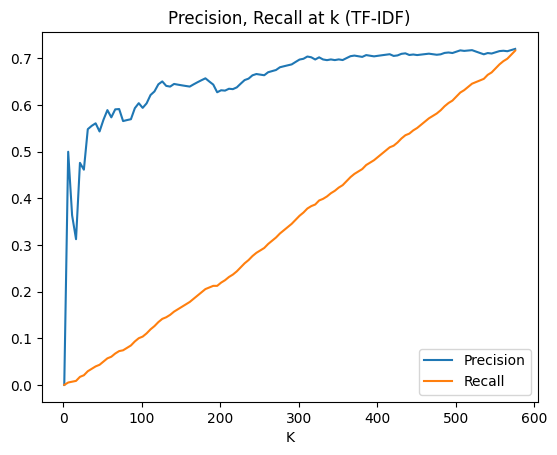

In [109]:
k_video_precision_tfidf = {k: precision(
    test['like'], test['pred_like_tfidf'], k) for k in range(1, len(test)+1, 5)}
k_video_recall_tfidf = {k: recall(
    test['like'], test['pred_like_tfidf'], k) for k in range(1, len(test)+1, 5)}

plt.title("Precision, Recall at k (TF-IDF)")
plt.plot(k_video_precision_tfidf.keys(),
         k_video_precision_tfidf.values(), label='Precision')
plt.plot(k_video_recall_tfidf.keys(),
         k_video_recall_tfidf.values(), label='Recall')
plt.xlabel('K')
plt.legend()
plt.show()

# Word to Vec


In [17]:
from gensim import models
# GitHub: https://test.ocom.vn/?url=github.com/sonvx/word2vecVN
word2vec_path = 'word2vec_model/baomoi.window2.vn.model.bin.gz'
w2v_model = models.KeyedVectors.load_word2vec_format(
    word2vec_path, binary=True)


In [18]:
vocab = w2v_model.wv.vocab
print("The total number of words:", len(vocab))


The total number of words: 439056


In [19]:
# update vocab of w2v based on pretrained-embedding
w2v_model_2 = models.Word2Vec(size=300, min_count=1)
w2v_model_2.build_vocab(train['desc_cleaned'])
total_examples = w2v_model_2.corpus_count
w2v_model_2.build_vocab([list(w2v_model.wv.vocab)], update=True)
w2v_model_2.intersect_word2vec_format(word2vec_path, binary=True, lockf=1.0)
w2v_model_2.train(train['desc_cleaned'],
                  total_examples=total_examples, epochs=w2v_model_2.iter)


(10963, 12425)

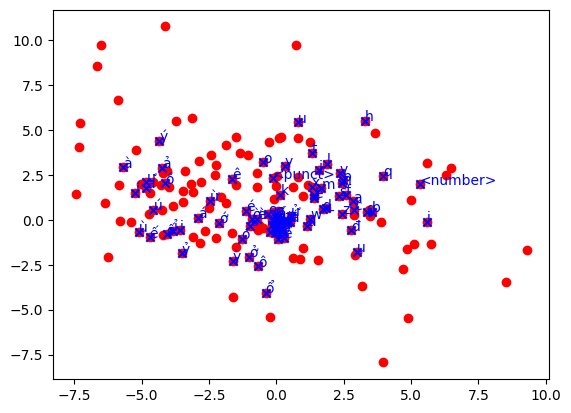

In [20]:
from sklearn.decomposition import PCA
# fit a 2d PCA model to the vectors
X = w2v_model_2[w2v_model_2.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:200, 0], result[:200, 1], c='red')
words = list(w2v_model_2.wv.vocab)[:100]
for i, word in enumerate(words):
    plt.scatter(result[i, 0], result[i, 1], c='blue', marker='x')
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), color='blue')
plt.show()


In [21]:
max_length = 0
for val in history['desc_video']:
    len_sentence = len(str(val).split())
    if len_sentence > max_length:
        max_length = len_sentence
print("Sentences have max %d lengths" % max_length)


Sentences have max 70 lengths


In [22]:
import torch
dim = 300  # dimension of a word vector
enc_descr_processed = []

for descr in history['desc_cleaned']:
    descr_list = descr.split()
    w2v = []
    for val in descr_list:
        try:
            _ = w2v_model_2.wv.get_vector(val)
        except KeyError:
            # if word isn't in vocab,
            # assign it to zeros vector have 300 dim
            _ = np.zeros((dim,))
        w2v.append(_)
    # w2v = torch.tensor(w2v)
    enc_descr_processed.append(w2v)


In [23]:
from keras.utils import pad_sequences
# padding sentences to have equal length
enc_descr_processed = pad_sequences(enc_descr_processed, maxlen=max_length, dtype='float',
                                    padding='post', value=np.zeros(dim))
enc_descr_processed = torch.from_numpy(enc_descr_processed)
enc_descr_processed.shape


torch.Size([643, 70, 300])

In [24]:
from sklearn.model_selection import train_test_split
# train test split
train_enc, test_enc = train_test_split(
    enc_descr_processed, train_size=0.1, shuffle=False)


In [25]:
content_profile = torch.mean(train_enc[indices_liked_train], dim=0)
content_profile.shape


torch.Size([70, 300])

In [26]:
from torch.nn import functional as F
sim_matrix_test = [torch.mean(
    F.cosine_similarity(content_profile, t_enc)).item() for t_enc in test_enc]


In [27]:
def recommend_video_based_on_desc(dataset, similarity_score, num_video=-1, print_details=False):
    # get similarity values with other video
    # sort in descending order the similarity score of movie inputted with all the other videos
    similarity_score = sorted(
        similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar videos. Ignore the first movie.
    if num_video > 0:
        similarity_score = similarity_score[:num_video]
    if print_details:
        print("Recommend", end=" ")
        if num_video:
            print(f"{num_video}", end=" ")
        print('videos are similar for user based on watched videos.')
    # return movie names using the mapping series
    video_indices = {dataset['id'].values[idx[0]]: idx[1]
                     for idx in similarity_score}
    if print_details:
        for i, v in video_indices.items():
            print(f"-> Video has id \"{i}\" with similarity: {v}")
    return video_indices


In [28]:
similarity_score = list(enumerate(sim_matrix_test))
rec_test_video_embedding = recommend_video_based_on_desc(
    test, similarity_score)


In [29]:
test['id_recommend_embedding'], test['watched_video_embedding_similarity'] = rec_test_video_embedding.keys(
), rec_test_video.values()

test['pred_like_embedding'] = test['id_recommend_embedding'].apply(
    lambda x: 1 if x in liked_videos else 0)


### Evaluate


In [94]:
k_ = len(test)
precision_embedding = precision(test['like'], test['pred_like_embedding'], k_)
recall_embedding = recall(test['like'], test['pred_like_embedding'], k_)
print('Precision on the test-set:', precision_embedding)
print('Recall on the test-set:', recall_embedding)


Precision on the test-set: 0.7271157167530224
Recall on the test-set: 0.7271157167530224


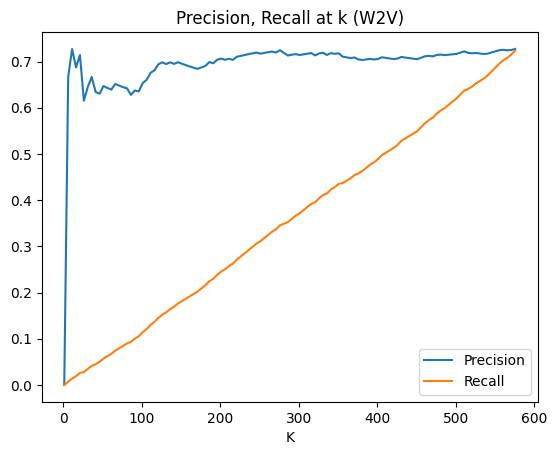

In [108]:
k_video_precision_embedding = {k: precision(
    test['like'], test['pred_like_embedding'], k) for k in range(1, len(test)+1, 5)}
k_video_recall_embedding = {k: recall(
    test['like'], test['pred_like_embedding'], k) for k in range(1, len(test)+1, 5)}

plt.title("Precision, Recall at k (W2V)")
plt.plot(k_video_precision_embedding.keys(),
         k_video_precision_embedding.values(), label='Precision')
plt.plot(k_video_recall_embedding.keys(),
         k_video_recall_embedding.values(), label='Recall')
plt.xlabel('K')
plt.legend()
plt.show()
